# Oxidation states
Here, we will demonstrate the main functionalities of the `oxidation_states` submodule of SMACT.

TO-DO
* Modify composition generation by SMACT to reproduce exact results from the paper

In [1]:
# Imports
import smact
from smact import Species, Element, screening
from smact.oxidation_states import Oxidation_state_probability_finder
from itertools import combinations, product
import multiprocess

In [2]:
# Instantiate the oxidation state probability finder class with the default table
ox_prob_finder = Oxidation_state_probability_finder()

After instantiating the class, we can examine what species are included in the probability table through the `get_included_species` method.

In [3]:
print(ox_prob_finder.get_included_species())

['Te-2', 'Se-2', 'Br-1', 'O-2', 'S-2', 'F-1', 'Cl-1', 'I-1', 'V5', 'Bi1', 'Hg2', 'Eu2', 'Ta1', 'Zr1', 'Pb2', 'Th4', 'Cr4', 'Ti2', 'Be2', 'Sb4', 'Re5', 'Sb3', 'Mo6', 'Ni3', 'Ga2', 'Nd3', 'Ni1', 'Cr6', 'Mn6', 'In3', 'V3', 'La3', 'W3', 'Ho2', 'Ta4', 'Cu1', 'W5', 'Cr3', 'Fe1', 'Re6', 'Rb1', 'Sm3', 'Pd2', 'Ce3', 'Sc2', 'Cr5', 'Tm3', 'W4', 'Pr3', 'Mo2', 'Ag3', 'Ir3', 'Li1', 'Cs1', 'Mn4', 'Al3', 'V4', 'Mn1', 'Rh1', 'Ru5', 'La1', 'Bi5', 'Cd2', 'Ce2', 'Yb3', 'Ru2', 'Ru3', 'Cr2', 'Co3', 'Na1', 'Ru4', 'Ag1', 'Zn2', 'Pb4', 'Mn2', 'Ir6', 'Ta3', 'Tb1', 'K1', 'Ti4', 'Rh3', 'Nb1', 'Ti3', 'Sr2', 'Y3', 'Gd3', 'Ta2', 'Zr2', 'Gd2', 'Th3', 'Lu3', 'Tm2', 'Sn3', 'Ca2', 'Nb3', 'Re3', 'Cu2', 'Er3', 'Bi3', 'V2', 'Fe2', 'Sb5', 'Mg2', 'Ce4', 'Ta5', 'U6', 'Nb2', 'Ag2', 'Re4', 'Yb2', 'In2', 'Ga1', 'Tb3', 'Mn7', 'La2', 'Tl1', 'Bi2', 'Mn3', 'Ho3', 'Rh4', 'Tl3', 'U2', 'Fe4', 'Ge2', 'Mo3', 'Pr2', 'U3', 'W6', 'Ni4', 'Fe3', 'Ga3', 'Ba2', 'In1', 'Re2', 'Sn4', 'Ir4', 'Sn2', 'U4', 'U5', 'Zr3', 'Nb4', 'Zr4', 'Eu3', 'Pd4', 'Y

We can compute the probability of a cation-anion pair appearing together using the method `pair_probability` as demonstrated below for Al<sup>3+</sup> and O<sup>2-</sup>.

In [4]:
Al=Species('Al', oxidation = 3, coordination=6)
O=Species('O', oxidation=-2, coordination=6)
ox_prob_finder.pair_probability(Al,O)

1.0

Let's reproduce the results from the publication.
First we will generate the input compositions from the paper.

In [5]:
# Get the elements

all_el = smact.element_dictionary()
symbol_list = [k for k,i in all_el.items()]

d_block_symbols = smact.ordered_elements(21,30) + smact.ordered_elements(39,48) + smact.ordered_elements(71,80)

d_block_elements = [all_el[x] for x in symbol_list if x in d_block_symbols]

d_block_combos = combinations(d_block_elements,2)

def smact_filter(els):
    all_compounds = []
    halide_symbols = ['F','Cl','Br','I']

    for halide in halide_symbols:
        elements = [e.symbol for e in els] +[halide]

        # Get the Pauling electronegativities
        paul_a, paul_b, paul_x = els[0].pauling_eneg, els[1].pauling_eneg, Element(halide).pauling_eneg
        electronegativities = [paul_a, paul_b, paul_x]
    
        # For each set of species (in oxidation states) apply both SMACT tests
        for ox_a, ox_b in product(els[0].oxidation_states, 
                        els[1].oxidation_states):      
            ox_states = [ox_a, ox_b, -1]
            # Test for charge balance
            cn_e, cn_r = smact.neutral_ratios(ox_states, threshold = 8)
            if cn_e:
                # Electronegativity test
                electroneg_OK = screening.pauling_test(ox_states, electronegativities)
                if electroneg_OK:
                    compound = tuple([elements,(ox_a,ox_b,-1),cn_r[0]])
                    all_compounds.append(compound)
    return all_compounds


In [6]:
with multiprocess.Pool(3) as p:
    result = p.map(smact_filter, d_block_combos)
    
flat_list = [item for sublist in result for item in sublist]
print("Number of compositions: {0}".format(len(flat_list)))
print('Each list entry looks like this:\n  elements, oxidation states, stoichiometries')
for i in flat_list[:5]:
    print(i)


Number of compositions: 38788
Each list entry looks like this:
  elements, oxidation states, stoichiometries
(['Sc', 'Ti', 'F'], (1, -1, -1), (2, 1, 1))
(['Sc', 'Ti', 'F'], (1, 1, -1), (1, 1, 2))
(['Sc', 'Ti', 'F'], (1, 2, -1), (1, 1, 3))
(['Sc', 'Ti', 'F'], (1, 3, -1), (1, 1, 4))
(['Sc', 'Ti', 'F'], (1, 4, -1), (1, 1, 5))


In [7]:
from pymatgen.core import Composition
def comp_maker(comp):
    form = []
    for el, ammt in zip(comp[0], comp[2]):
        form.append(el)
        form.append(ammt)
    form = ''.join(str(e) for e in form)
    pmg_form = Composition(form).reduced_formula
    return pmg_form

if __name__ == '__main__':  
    with multiprocess.Pool(3) as p:
        pretty_formulas = p.map(comp_maker, flat_list)

print('Each list entry now looks like this: ')
for i in pretty_formulas[:5]:
    print(i)

Each list entry now looks like this: 
Sc2TiF
ScTiF2
ScTiF3
ScTiF4
ScTiF5


Below, we convert our list of elements, oxidation_states, stoichiometries into a list of lists of `smact.Species`.

In [8]:
import pandas as pd
def species_maker(comp):
    species_list=[]
    for el, ox in zip(comp[0], comp[1]):
        species_list.append(Species(el,oxidation=ox))
    return species_list
if __name__ == '__main__':  
    with multiprocess.Pool(3) as p:
        list_of_species = p.map(species_maker, flat_list)

The method `compound_probability` of the `Oxidation_state_probability_finder` class enables us to compute the likelihood of the metal species existing in the presence of particular anions. We will apply this to all the compounds generated by `smact`

In [9]:

def compute_compound_probability(species_list):
    try:
       return ox_prob_finder.compound_probability(species_list)
    except NameError:
        return None

# Compute the compound probabilities 
compound_probabilities = [compute_compound_probability(spec) for spec in list_of_species]

In [10]:
# Create a dataframe
data = {'formula_pretty':pretty_formulas, 'prob': compound_probabilities}

df = pd.DataFrame(data)
df.head()

,formula_pretty,prob
0,Sc2TiF,0.000000
1,ScTiF2,NaN
2,ScTiF3,0.019608
3,ScTiF4,0.176471
4,ScTiF5,0.303922


In [11]:
# Get the dataframe without the None probabilities
notNone_df=df.dropna(axis=0).reset_index(drop=True)

# Get the dataframe with the non-zero probabilities
nonZero_df= notNone_df.loc[notNone_df.prob>0].reset_index(drop=True)

print(f'Our original smact query generated {len(pretty_formulas)} compositions. \nWe could compute compute compound probabilities for {notNone_df.shape[0]} compositions. \nFinally, there are {nonZero_df.shape[0]} compositions which have a non-zero compound probability.')

Our original smact query generated 38788 compositions. 
We could compute compute compound probabilities for 20360 compositions. 
Finally, there are 15884 compositions which have a non-zero compound probability.


We will know plot the number of compounds as a function of the probability threshold.

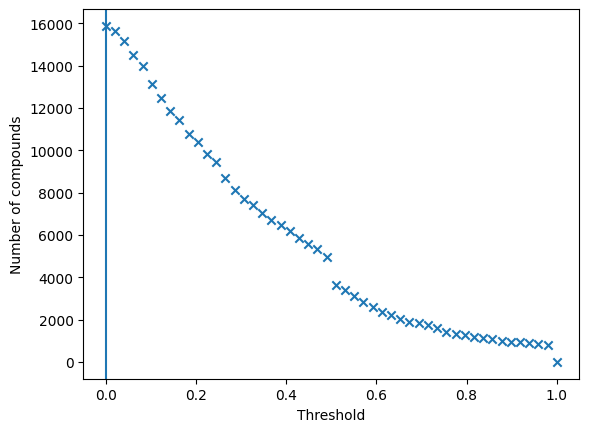

In [12]:
import numpy as np
import matplotlib.pyplot as plt

thresh = np.linspace(0.0,1.0,50)
probs = notNone_df.prob.to_numpy()
condition = (probs>0.5)
filtered_probs = probs[condition]
num_compounds = [len(probs[(probs>t)]) for t in thresh]

fig,ax = plt.subplots()

ax.scatter(x=thresh, y=num_compounds, marker='x')
plt.xlabel('Threshold')
plt.ylabel('Number of compounds')
ax.axvline()
plt.show()